# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV207"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 15

In [5]:
# OUTPUT_FIGURES_DIR = Path(
#     conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
# ).resolve()
# display(OUTPUT_FIGURES_DIR)
# OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
# OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
# display(OUTPUT_CELL_TYPE_FILEPATH)

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases/phenoplier/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [44]:
lv_obj.lv_genes.head(20)

,gene_name,LV207,gene_band
0,ERBB2,5.307980,17q12
1,PSMD3,2.495105,17q21.1
2,LLGL2,2.293986,17q25.1
3,CRABP2,2.173649,1q23.1
4,FGFR4,2.132309,5q35.2
5,PPP1R1B,2.118459,17q12
6,GALNT6,2.083479,12q13.13
7,INHBB,2.021482,2q14.2
8,G6PD,1.691048,NaN
9,P2RY6,1.672677,11q13.4


In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-09-29 10:45:26,068 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP026537, SRP064259, SRP042620, SRP011974, SRP006575, SRP030475, SRP049500, SRP019207, SRP037775, SRP023262, SRP049507, SRP058571, SRP050365, SRP019498, SRP006726, SRP055512, SRP065202, SRP063620, SRP044611, SRP049988, SRP043320, SRP048536, SRP062287, SRP020493, SRP030401, SRP004847, SRP033250, SRP066956, SRP044917, SRP014027, SRP004637, SRP019936, SRP061241, SRP058722, SRP052950, SRP040505, SRP048664, SRP034528, SRP040998, SRP065559, SRP009862, SRP043593, SRP029207, SRP034657, SRP028887, SRP006719, SRP051544, SRP042616, SRP009266, SRP049713, SRP040418, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:323: UserWarning: Not all experiments data could be loaded (48 != 51)
  warnings.warn(


In [19]:
lv_data.shape

(1215, 73)

In [20]:
lv_data.head()

cell line      cell type        subtype tissue  \
project   run                                                        
SRP026537 SRR925687     184A1  breast cancer  Non-malignant    NaN   
          SRR925688     184B5  breast cancer  Non-malignant    NaN   
          SRR925689     21MT1  breast cancer          Basal    NaN   
          SRR925690     21MT2  breast cancer          Basal    NaN   
          SRR925691      21NT  breast cancer          Basal    NaN   

                    disease status Stage developmental stage  \
project   run                                                  
SRP026537 SRR925687            NaN   NaN                 NaN   
          SRR925688            NaN   NaN                 NaN   
          SRR925689            NaN   NaN                 NaN   
          SRR925690            NaN   NaN                 NaN   
          SRR925691            NaN   NaN                 NaN   

                    tissue archive method genotype experimental set  ...  \
project   run                                                        ...   
SRP026537 SRR925687                   NaN      NaN              NaN  ...   
          SRR925688                   NaN      NaN              NaN  ...   
          SRR925689                   NaN      NaN              NaN  ...   
          SRR925690                   NaN      NaN              NaN  ...   
          SRR925691                   NaN      NaN              NaN  ...   

                    rna prep purification read length group_tag cell  \
project   run                                                          
SRP026537 SRR925687      NaN          NaN         NaN       NaN  NaN   
          SRR925688      NaN          NaN         NaN       NaN  NaN   
          SRR925689      NaN          NaN         NaN       NaN  NaN   
          SRR925690      NaN          NaN         NaN       NaN  NaN   
          SRR925691      NaN          NaN         NaN       NaN  NaN   

                    cell subtype  Sex culture collection biomaterial provider  \
project   run                                                                   
SRP026537 SRR925687          NaN  NaN                NaN                  NaN   
          SRR925688          NaN  NaN                NaN                  NaN   
          SRR925689          NaN  NaN                NaN                  NaN   
          SRR925690          NaN  NaN                NaN                  NaN   
          SRR925691          NaN  NaN                NaN                  NaN   

                        LV207  
project   run                  
SRP026537 SRR925687  0.066890  
          SRR925688  0.114638  
          SRR925689  0.294262  
          SRR925690  0.238002  
          SRR925691  0.267479  

[5 rows x 73 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

Stage                                     0.194573
subtype                                   0.173657
cancer subtype                            0.104108
gender                                    0.099090
genotype                                  0.094710
culture condition                         0.086972
type of cd24                              0.086972
knock down                                0.086972
cell type                                 0.082257
disease status                            0.072713
cell line                                 0.072321
resistance                                0.061725
drug treatment                            0.060558
passage                                   0.029558
growth media                              0.028352
sample molecule                           0.025782
tissue                                    0.024319
individual                                0.024039
treatment- reagent                        0.020809
treatment- knockdown v. overexp

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type       0.082257
tissue          0.024319
tissue type     0.008734
cell subtype    0.002559
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        "tissue type",
        "cell subtype",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[2]

cell type                   tissue  \
project   run                                                                
SRP037775 SRR1168737  HER2-positive breast cancer                      NaN   
          SRR1168743  HER2-positive breast cancer                      NaN   
          SRR1168733  HER2-positive breast cancer                      NaN   
          SRR1168735  HER2-positive breast cancer                      NaN   
          SRR1168740  HER2-positive breast cancer                      NaN   
          SRR1168741  HER2-positive breast cancer                      NaN   
          SRR1168734  HER2-positive breast cancer                      NaN   
          SRR1168746  HER2-positive breast cancer                      NaN   
          SRR1168742  HER2-positive breast cancer                      NaN   
          SRR1168736  HER2-positive breast cancer                      NaN   
          SRR1168739  HER2-positive breast cancer                      NaN   
          SRR1168744  HER2-positive breast cancer                      NaN   
          SRR1168738  HER2-positive breast cancer                      NaN   
SRP023262 SRR868863                           NaN                   breast   
SRP064259 SRR2532318      breast cancer cell line                      NaN   
SRP042620 SRR1313079                          NaN  Breast Cancer Cell Line   
SRP049500 SRR1639638      Breast Cancer cell line                      NaN   
SRP064259 SRR2532392      breast cancer cell line                      NaN   
SRP049507 SRR1639743                        HER2+                      NaN   
SRP064259 SRR2532384      breast cancer cell line                      NaN   
          SRR2532376      breast cancer cell line                      NaN   
SRP026537 SRR925700                 breast cancer                      NaN   
SRP006575 SRR537132           breast cancer cells                      NaN   
SRP064259 SRR2532344      breast cancer cell line                      NaN   
SRP006575 SRR537130           breast cancer cells                      NaN   

                     tissue type cell subtype     LV207  
project   run                                            
SRP037775 SRR1168737         NaN          NaN  0.770692  
          SRR1168743         NaN          NaN  0.769183  
          SRR1168733         NaN          NaN  0.767733  
          SRR1168735         NaN          NaN  0.766716  
          SRR1168740         NaN          NaN  0.766085  
          SRR1168741         NaN          NaN  0.765746  
          SRR1168734         NaN          NaN  0.764671  
          SRR1168746         NaN          NaN  0.762963  
          SRR1168742         NaN          NaN  0.762198  
          SRR1168736         NaN          NaN  0.759725  
          SRR1168739         NaN          NaN  0.759019  
          SRR1168744         NaN          NaN  0.757797  
          SRR1168738         NaN          NaN  0.756271  
SRP023262 SRR868863          NaN          NaN  0.734824  
SRP064259 SRR2532318         NaN          NaN  0.728098  
SRP042620 SRR1313079         NaN          NaN  0.701796  
SRP049500 SRR1639638         NaN          NaN  0.693834  
SRP064259 SRR2532392         NaN          NaN  0.675326  
SRP049507 SRR1639743         NaN          NaN  0.668840  
SRP064259 SRR2532384         NaN          NaN  0.655314  
          SRR2532376         NaN          NaN  0.647641  
SRP026537 SRR925700          NaN          NaN  0.638597  
SRP006575 SRR537132          NaN          NaN  0.633632  
SRP064259 SRR2532344         NaN          NaN  0.620003  
SRP006575 SRR537130          NaN          NaN  0.607542

In [26]:
# # what is there in these projects?
# lv_data.loc[["SRP007412"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).sort_values(LV_NAME, ascending=False).head(10)

**No cell types/tissues/cell lines** so not very interesting

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = [
    "tissue",
    #     "tissue subtype"
]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type     LV207
project   run                                                  
SRP026537 SRR934645                     breast cancer  1.976458
          SRR934644                     breast cancer  1.750343
SRP064259 SRR2532393          breast cancer cell line  1.682502
SRP042620 SRR1313098  ER+ Breast Cancer Primary Tumor  1.455198
SRP026537 SRR934640                     breast cancer  1.318931
          SRR925694                     breast cancer  1.308988
          SRR934641                     breast cancer  1.286711
          SRR934642                     breast cancer  1.221695
          SRR934632                     breast cancer  1.175718
          SRR934631                     breast cancer  1.155347
          SRR934643                     breast cancer  1.116380
SRP011974 SRR449336                   NOT CATEGORIZED  1.114806
          SRR449337                   NOT CATEGORIZED  1.100648
SRP006575 SRR537128               breast cancer cells  1.070650
SRP042620 SRR1313081          Breast Cancer Cell Line  1.013607
SRP026537 SRR1283038          breast cancer cell line  0.993671
SRP006575 SRR537131               breast cancer cells  0.991355
SRP026537 SRR925704                     breast cancer  0.978535
SRP030475 SRR1002999                  NOT CATEGORIZED  0.928411
SRP026537 SRR925699                     breast cancer  0.922048

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            #             "normal skin": "Skin",
            #             "liver": "Liver",
            #             "Human Skeletal Muscle Myoblasts (HSMM)": "Skeletal muscle myoblasts",
            #             "astrocytes": "Astrocytes",
            #             "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma cells + lung fibroblast cells",
            #             "functional hepatocytes generated by lineage reprogramming": "Hepatocytes",
            #             "human adipose-derived stem cells": "Adipose-derived stem cells",
            #             "adipose": "Adipose",
            #             "embryonic stem cells": "Embryonic stem cells",
            #             "primary keratinocytes": "Primary keratinocytes",
            #             "fetal liver": "Fetal liver",
            #             "in vitro differentiated erythroid cells": "Erythroid cells",
            #             "WAT": "White adipose tissue",
            #             "BAT": "Brown adipose tissue",
            #             "Uninvolved Breast Tissue Adjacent to ER+ Primary Tumor": "Breast tissue adjacent to ER+ tumor",
            #             "ovarian granulosa cells": "Ovarian granulosa cells",
            "mixture of U87 human glioma cells and MCF10a human breast cancer cells": "glioma cells + breast cancer cells",
        }
    }
)

In [34]:
# # add also tissue information to these projects
# _srp_code = "SRP057196"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: x[SELECTED_ATTRIBUTE]
#     + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [35]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [36]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [37]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

15

In [40]:
attr_order[:5]

['breast cancer',
 'breast cancer cell line',
 'ER+ Breast Cancer Primary Tumor',
 'breast cancer cells',
 'Breast Cancer Cell Line']

## Plot

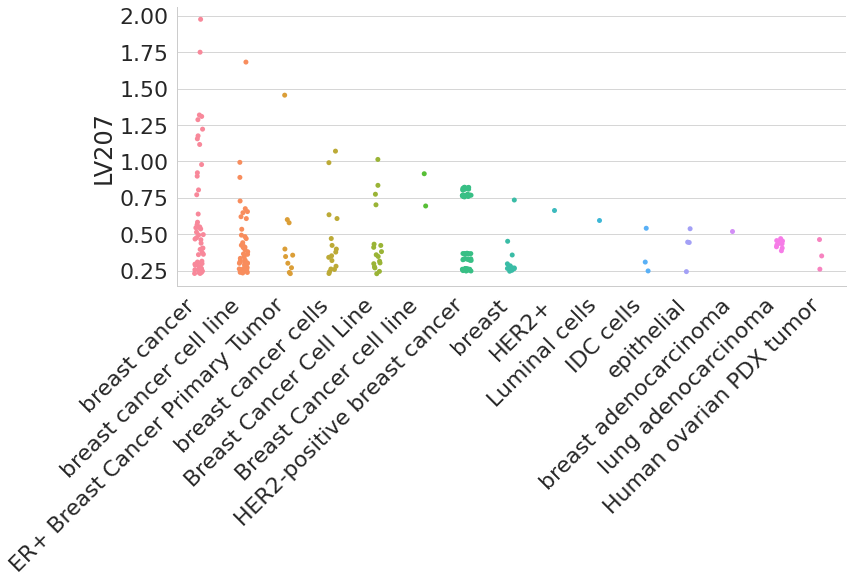

In [41]:
with sns.plotting_context("paper", font_scale=2.5), sns.axes_style("whitegrid"):
    g = sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=2.5,
    )
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.xlabel("")

#     plt.savefig(
#         OUTPUT_CELL_TYPE_FILEPATH,
#         bbox_inches="tight",
#         facecolor="white",
#     )

# Debug

In [42]:
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
):
    _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("NOT CAT")]
    display(_tmp.head(20))

,,cell type,LV207
project,run,,


In [43]:
# # what is there in these projects?
# lv_data.loc[["SRP056041"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)